In [ ]:
%matplotlib inline

In [2]:
import sys
import os 
from glob import glob
import json

In [3]:
sys.path.insert(0, '../../')

In [4]:
import paleopy

In [5]:
from paleopy import plotting

In [6]:
from paleopy import Proxy 
from paleopy import Analogs
from paleopy import Ensemble
from paleopy.plotting import scalar_plot

In [ ]:
# %load /Users/nicolasf/CODE/paleopy/paleopy/plotting/vector_plot.py
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
import palettable
from scipy.stats import scoreatpercentile

class vector_plot:
    """
    plots vector plots (uwnd + vwnd) on top of geopotential anomalies (hgt)

    Parameters
    ----------

    ucompos : object, composite anomalies and metadata for zonal wind component
            a composite object coming from e.g. `uwnd_1000 = analogs(ens, 'ncep', 'uwnd_1000').composite()`

    vcompos : object, composite anomalies and metadata for meridional wind component
            a composite object coming from e.g. `vwnd_1000 = analogs(ens, 'ncep', 'vwnd_1000').composite()`

    hgtcompos : object, composite anomalies and metadata for HGT
            a composite object coming from e.g. `hgt_1000 = analogs(ens, 'ncep', 'hgt_1000').composite()`

    """
    def __init__(self, ucompos, vcompos, hgtcompos):

        """
        these are the composite objects
        """
        self.hgtcompos = hgtcompos
        self.ucompos = ucompos
        self.vcompos = vcompos

        """
        these are the datasets containing the composite anomalies and tests
        """
        self.windspeed_dset = (self.ucompos.dset_compos ** 2 + self.vcompos.dset_compos ** 2).apply(np.sqrt)
        self.uwnd_dset  = ucompos.dset_compos
        self.vwnd_dset  = vcompos.dset_compos
        self.hgt_dset  = hgtcompos.dset_compos

    def _get_levels(self, data):
        """
        data can be either the data array attached to:

        + self.analogs.dset_compos['composite_anomalies']

        or one of the data arrays attached to

        + self.analogs.dset_compos['composite_sample']
        """

        # ravel and removes nans for calculation of intervals etc
        calc_data = np.ravel(data[np.isfinite(data)])

        # the following is borrowed from xray
        # see: plot.py in xray/xray/plot
        vmin = np.percentile(calc_data, 1)
        vmax = np.percentile(calc_data, 99)

        del(calc_data)

        # Simple heuristics for whether these data should  have a divergent map
        divergent = ((vmin < 0) and (vmax > 0))

        # A divergent map should be symmetric around the center value
        if divergent:
            center = 0
            vlim = max(abs(vmin), abs(vmax))
            vmin, vmax = -vlim, vlim

        if (vmin.dtype == 'float64') and (vmax.dtype == 'float64'):
            vmin = float("{:6.2f}".format(vmin))
            vmax = float("{:6.2f}".format(vmax))

        levels = np.linspace(vmin, vmax, num=10, endpoint=True)

        if divergent:
            neglevels = levels[levels < 0 ]
            poslevels = levels[levels > 0 ]
            levels = [neglevels,poslevels]
            # get the colormap defined in the dset_dict for HGT
            cmap = eval(self.hgtcompos.dset_dict['plot']['cmap'])
        else:
            # get the default matplotlib colormap
            cmap = plt.get_cmap()

        return vmin, vmax, levels, cmap

    def plot(self, domain = None, res='c', stepp=1, scale=None, test=0.1):

        """
        if the domain is actually defined, we select in lat and lon, making sure the
        latitudes are increasing (from South to North)

        scale needs to be determined empirically

        for 850 hPa, 8 works well

        for 200 hPa, 15 works well

        """

        if domain is not None:

            latrev = (self.windspeed.latitudes[-1] < self.windspeed.latitudes[0])

            if latrev:
                ugrid = self.uwnd_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
                vgrid = self.vwnd_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
                hgrid = self.hgt_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
                wgrid = self.windspeed_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
            else:
                ugrid = self.uwnd_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))
                vgrid = self.vwnd_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))
                hgrid = self.hgt_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))
                wgrid = self.windspeed_dset.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))

        else:

            ugrid = self.uwnd_dset
            vgrid = self.vwnd_dset
            hgrid = self.hgt_dset
            wgrid = self.windspeed_dset

        latitudes = wgrid.latitudes.data
        longitudes = wgrid.longitudes.data

        m = bm(projection='cyl',llcrnrlat=latitudes.min(),urcrnrlat=latitudes.max(),\
        llcrnrlon=longitudes.min(),urcrnrlon=longitudes.max(),\
        lat_ts=0, resolution=res, area_thresh=10000)

        lons, lats = np.meshgrid(longitudes, latitudes)

        # this colormap is quite good for wind speed
        # cmap = palettable.colorbrewer.sequential.Oranges_9.mpl_colormap


        """
        get the width and height of the figure
        """

        w = 10

        h = np.ceil( (wgrid['composite_anomalies'].shape[0] / wgrid['composite_anomalies'].shape[1]) *  10 )

        f, ax = plt.subplots(figsize=(w,h))

        m.ax = ax

        m.drawmeridians(np.arange(0., 360. + 60, 60.), labels=[0,0,0,1], color='0.4', linewidth=0.5)
        m.drawparallels(np.arange(-80., 80. + 40., 40.), labels=[1,0,0,0], color='0.4', linewidth=0.5)

        """
        get the min, max, levels (for contours) and colormap
        """

        vmin, vmax, levels, cmap = self._get_levels(hgrid['composite_anomalies'].data)

        """
        plot using pcolormesh
        """

        im = m.pcolormesh(lons, lats, hgrid['composite_anomalies'].data, cmap=cmap, vmin=vmin, vmax=vmax, latlon=True)

        # this if we want filled contours

#         im = m.contourf(lons, lats, hgrid['composite_anomalies'].data, cmap=cmap, levels=list(chain(*levels)), latlon=True, extend='both')


        cb = m.colorbar(im)

        cb.set_label("{}, {}".format(self.hgtcompos.dset_dict['short_description'], self.hgtcompos.dset_dict['units']), fontsize=14)

        ax.set_title("geopotential at 850 hPa \n{} and {}".format(self.ucompos.dset_dict['description'], \
                                                     self.vcompos.dset_dict['description']), fontsize=14)

        """
        plots the contours for HGT: not needed anymore
        """

#         if len(levels) == 2:
#             cn = m.contour(lons, lats, hgrid.data, levels = levels[0], cmap=plt.get_cmap('Blues'), linestyles='solid', latlon=True)
#             cp = m.contour(lons, lats, hgrid.data, levels = levels[1], cmap=plt.get_cmap('Reds'), latlon=True)
#         else:
#             if hgrid.data.min() < 0:
#                 cn = m.contour(lons, lats, hgrid.data, levels = levels[0], cmap=plt.get_cmap('Blues'), linestyles='solid', latlon=True)
#             elif hgrid.data.min() > 0:
#                 cp = m.contour(lons, lats, hgrid.data, levels = levels[1], cmap=plt.get_cmap('Reds'), latlon=True)

        # plt.clabel(cn, fmt = '%4.0f', fontsize = 12, alpha=0.8, colors='k')
        # plt.clabel(cp, fmt = '%4.0f', fontsize = 12, alpha=0.8, colors='k')

        """
        get the steps and plots the wind vectors ... stepp cannot really be determined
        automatically and is therefore a parameter of the method `plotmap` of the class `vector_plot`
        """

        yy = np.arange(0, lats.shape[0], stepp)
        xx = np.arange(0, lons.shape[1], stepp)

        points = np.meshgrid(yy, xx)

        cmap_wind = palettable.colorbrewer.sequential.YlOrBr_9.mpl_colormap

#         Q = m.quiver(lons[points], lats[points], ugrid.data[points], vgrid.data[points], wgrid.data[points], \
#                      pivot='middle', scale=scale, cmap=plt.get_cmap('gray_r'), latlon=True)

        """
        if the scale is NOT defined, we try to determine a reasonable value
        given the wind speed anomalies
        """
        if scale is None:
            scale = 13 * wgrid['composite_anomalies'].max().data

        """
        set the headaxislength to about 1/2 of the headlength to have 'pointy' arrows
        """

        arrowprops = {}
        arrowprops['scale'] = scale
        arrowprops['width'] = 0.0015
        arrowprops['headlength'] = 8
        arrowprops['headaxislength'] = 4
        arrowprops['headwidth'] = 6
        arrowprops['pivot'] = 'middle'

        Q = m.quiver(lons[points], lats[points], ugrid['composite_anomalies'].data[points], vgrid['composite_anomalies'].data[points], color='0.4', latlon=True, **arrowprops)

        """
        the wind vectors for which uwnd OR UWND (or both) are significant are displayed in green
        """

        mask = np.logical_or((c.ucompos.dset_compos['pvalues'].data < 0.1),(c.vcompos.dset_compos['pvalues'].data < test))

        ugrid_test = ma.masked_array(ugrid['composite_anomalies'].data, ~mask)
        vgrid_test = ma.masked_array(vgrid['composite_anomalies'].data, ~mask)

        QT = m.quiver(lons[points], lats[points], ugrid_test[points], vgrid_test[points], color='g', latlon=True, **arrowprops)

#         headaxislength=4, headlength=8, headwidth=6

#         m.streamplot(lons, lats, ugrid.data, vgrid.data, color='k', latlon=True, density=2.5, cmap=plt.cm.gray_r, linewidth=3*wgrid.data)

        l,b,w,h = ax.get_position().bounds

        """
        determine the wind vector key length as the 95th percentile of the wind speed
        """

        wsq = np.round(scoreatpercentile(wgrid['composite_anomalies'].data, 95), decimals=1)

        qk = plt.quiverkey(Q, l+w-0.1, b-0.01, wsq, "{:4.2f} m/s".format(wsq), labelpos='E', fontproperties={'size':12}, coordinates='figure', zorder=20)

        m.drawcoastlines(color='0.2', linewidth=1)

        return f


In [24]:
plt.quiver?

In [15]:
djsons = '../../jsons/'
pjsons = '../../jsons/proxies'

In [16]:
from numpy import ma
import numpy as np
import xarray as xray

### test the new implementation of PALEOPY with just one proxy

In [17]:
p = Proxy(sitename='Rarotonga', \
          lon = -159.82, \
          lat = -21.23, \
          djsons = djsons, \
          pjsons = pjsons, \
          pfname = 'Rarotonga.json', \
          dataset = 'ersst', \
          variable ='sst', \
          measurement ='delta O18', \
          dating_convention = 'absolute', \
          calendar = 'gregorian',\
          chronology = 'historic', \
          season = 'DJF', \
          value = 0.6, \
          qualitative = 0, \
          calc_anoms = True, \
          detrend = True, \
        method = 'quintiles')

In [18]:
p.find_analogs()

In [19]:
p.proxy_repr(pprint=True, outfile=False)

{
sitename:Rarotonga
proxy_type:None
measurement:delta O18
dating_convention:absolute
calendar:gregorian
chronology:historic
coords:(200.18, -21.23)
aspect:None
elevation:None
season:DJF
dataset:ersst
variable:sst
calc_anoms:True
detrend:True
value:0.6
climatology:(1981, 2010)
period:(1979, 2014)
extracted_coords:[200.0, -22.0]
distance_point:87.56368858840081
trend_params:{'slope': 0.030535947029886677, 'intercept': -60.965016377755163}
category:WA
analog_years:[1982, 1997, 1999, 2000, 2001, 2006, 2009]
weights:[0.15645480307020584, 0.12800536294956205, 0.13090508326029401, 0.16334634614636281, 0.15762466128135916, 0.1220029495538857, 0.1416607937383304]
}


In [93]:
hgt = Analogs(p, 'ncep', 'hgt_200').composite()
uwnd = Analogs(p, 'ncep', 'uwnd_200').composite()
vwnd = Analogs(p, 'ncep', 'vwnd_200').composite()

In [99]:
c = vector_plot(uwnd, vwnd, hgt)

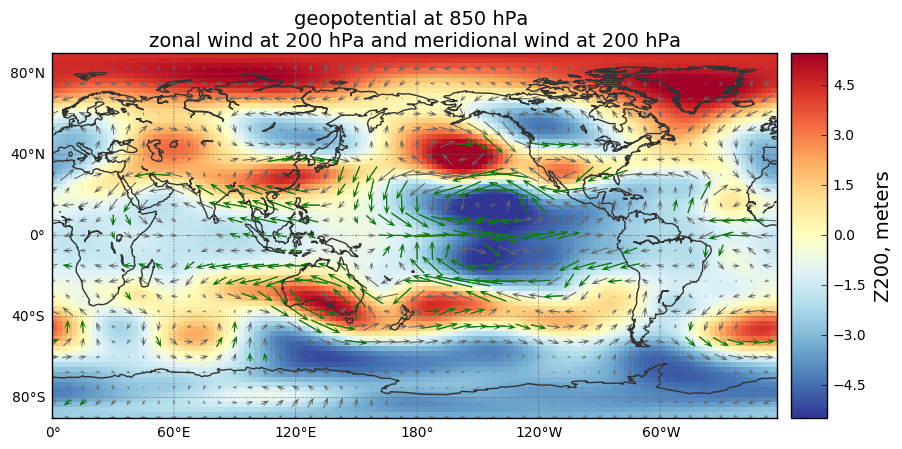

In [100]:
f = c.plot(stepp=3, res='c')

In [90]:
f.savefig('/Users/nicolasf/Desktop/example_wind_vector.png', dpi=200)

In [ ]:
c.ucompos.dset_compos['pvalues'].data 

In [ ]:
c.vcompos.dset_compos['pvalues'].data 

In [ ]:
test = ( (c.ucompos.dset_compos['pvalues'].data < 0.1) or (c.vcompos.dset_compos['pvalues'].data < 0.1) )

In [ ]:
mask = np.logical_or((c.ucompos.dset_compos['pvalues'].data < 0.1),(c.vcompos.dset_compos['pvalues'].data < 0.1))

In [ ]:
plt.imshow(c.windspeed_dset['composite_anomalies'].data[mask])

In [ ]:
mask.shape

In [ ]:
c.windspeed_dset['composite_anomalies'].data.shape

In [ ]:
plt.imshow(ma.masked_array(c.windspeed_dset['composite_anomalies'].data, ~mask))

In [ ]:
from itertools import chain

In [ ]:
levels

In [ ]:
vmin, vmax, levels, cmap = c._get_levels(c.hgtcompos.dset_compos['composite_anomalies'].data)

In [ ]:
levels

In [ ]:
15 / c.windspeed_dset['composite_anomalies'].max().data

In [ ]:
8 / c.windspeed_dset['composite_anomalies'].max().data

In [ ]:
13 * c.windspeed_dset['composite_anomalies'].max().data

In [75]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)

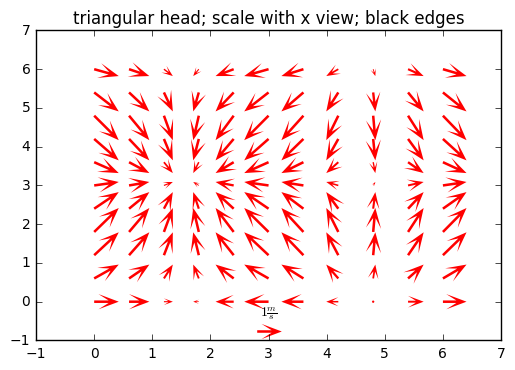

In [86]:
plt.figure()

Q = plt.quiver(X[::3, ::3], Y[::3, ::3], U[::3, ::3], V[::3, ::3],
               color='r', units='x', headaxislength=4, headlength=8, headwidth=6)


qk = plt.quiverkey(Q, 0.5, 0.03, 1, r'$1 \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
plt.axis([-1, 7, -1, 7])
plt.title("triangular head; scale with x view; black edges")

In [97]:
plt.quiver?